In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from datetime import datetime
from torch import nn
from torch.utils.data import dataloader
from methods import *

In [2]:
data = pd.read_csv("../data/voxmeter.csv")
data

,party_letter,votes,date
0,A,20.4,2025-09-28
1,B,4.2,2025-09-28
2,C,7.0,2025-09-28
3,F,12.0,2025-09-28
4,H,2.3,2025-09-28
...,...,...,...
151,O,6.8,2025-12-21
152,V,12.2,2025-12-21
153,Æ,10.0,2025-12-21
154,Ø,6.1,2025-12-21


In [3]:
blue_block = Block(parties="CHIOVÆ")
red_block = Block(parties="ABFØÅ")
goverment = Block(parties="AMV")
blue_block_outside = Block(parties="CHIOÆ")
red_block_outisde = Block(parties="BFØÅ")
blocks = [blue_block, red_block, goverment, blue_block_outside, red_block_outisde]

,votes
0,46.6
1,46.6
2,47.3
3,46.1
4,46.4
5,47.9
6,47.5
7,48.0
8,46.8
9,47.3


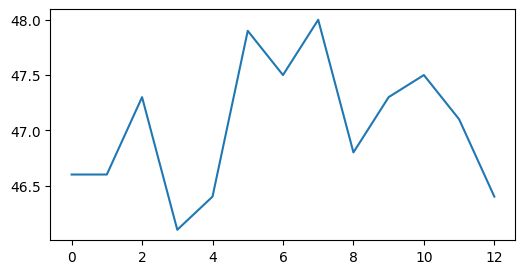

In [4]:
party_data = red_block.vote_history()
votes = party_data.get("votes").to_list() # type: ignore
display(party_data)
plt.figure(figsize=[6, 3])
plt.plot(range(len(votes)), votes)
plt.show()

In [5]:
party_data

,votes
0,46.6
1,46.6
2,47.3
3,46.1
4,46.4
5,47.9
6,47.5
7,48.0
8,46.8
9,47.3


In [6]:
X_train = torch.tensor(votes[:-1])
y_train = torch.tensor(votes[1:])
X_test = torch.tensor(votes[:-1])
y_test = torch.tensor(votes[-1])
print(f"X_train length: {len(X_train)}")
print(f"y_train length: {len(y_train)}")
print(f"X_test length: {X_test.numel()}")
print(f"y_test length: {y_test.numel()}")

X_train length: 12
y_train length: 12
X_test length: 12
y_test length: 1


In [7]:
sequince_length = 3
X, y = create_sequences(X_train.numpy(), seq_length=sequince_length)

trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [8]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Hidden state is reset for each epoch
    outputs, _, _ = model(trainX)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/500], Loss: 168.3674
Epoch [100/500], Loss: 0.4409
Epoch [150/500], Loss: 0.3729
Epoch [200/500], Loss: 0.3706
Epoch [250/500], Loss: 0.3706
Epoch [300/500], Loss: 0.3706
Epoch [350/500], Loss: 0.3706
Epoch [400/500], Loss: 0.3706
Epoch [450/500], Loss: 0.3706
Epoch [500/500], Loss: 0.3706


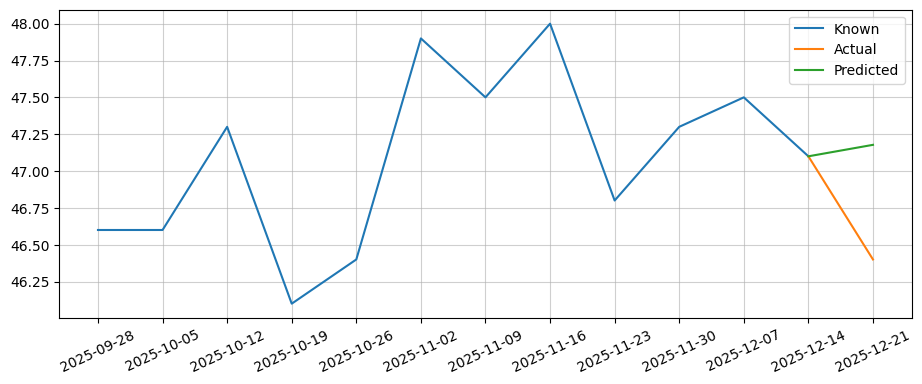

Predicted Vote: 47.18
Actual Vote: 46.40
MAE: 0.778


In [9]:
model.eval()

# Reshape X_test to (Batch Size, Sequence Length, Features)
# Use the last sequince_length elements for prediction
testX = X_test[-sequince_length:].view(1, -1, 1).float()

with torch.no_grad():
    y_pred, _, _ = model(testX)

dates = pd.to_datetime(data["date"].unique())
dates = dates.sort_values()

plt.figure(figsize=[11, 4])
plt.plot(dates[:-1], X_test, label="Known")
plt.plot(dates[-2:], torch.cat([X_test[-1].unsqueeze(0), y_test.unsqueeze(0)]), label="Actual")
plt.plot(dates[-2:], torch.cat([X_test[-1].unsqueeze(0), y_pred.flatten()]), label="Predicted")
plt.xticks(dates, rotation=25)
plt.grid(alpha=0.6)
plt.legend()
plt.show()

print(f"Predicted Vote: {y_pred.item():.2f}")
print(f"Actual Vote: {y_test.item():.2f}")
print(f"MAE: {abs((y_pred.item()-y_test.item())):.3f}")

In [12]:
def predict_result(X_test, weeks_forward):
    model.eval()

    # Reshape X_test to (Batch Size, Sequence Length, Features)
    # Use the last sequince_length elements for prediction
    testX = X_test[-sequince_length:].view(1, -1, 1).float()

    with torch.no_grad():
        y_pred, _, _ = model(testX)
    
    return testX

predict_result(X_test, weeks_forward=1)


    



tensor([[[47.3000],
         [47.5000],
         [47.1000]]])

In [ ]:
weeks_until_election = round((datetime.strptime("2026-04-04", "%Y-%m-%d")-datetime.strptime(datetime.today().strftime('%Y-%m-%d'), "%Y-%m-%d")).days/7)

dates = pd.to_datetime(data["date"].unique())
dates = dates.sort_values()

plt.figure(figsize=[11, 4])
plt.plot(dates[:-1], X_test, label="Known")
plt.xticks(dates, rotation=25)
plt.grid(alpha=0.6)
plt.legend()
plt.show()
